In [2]:
import mne
import scipy
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
import glob
from scipy.stats import zscore, pearsonr
from scipy import signal
%matplotlib widget

### Data preparation

**EEG signals:** Load EEGLAB datasets -> Re-reference -> Highpass filter

**Sound envelope:** Load sound envelope

*Both band-pass filtered between 2 and 9 Hz, and downsampled to 20 Hz*

In [33]:
%%capture
# Names and paths
eeg_path_head = '../../Experiments/data/AS/Audio/'
env_path_head = '../../Experiments/Audio/'
audionames, eeg_sets_paths, env_sets_paths = utils.name_paths(eeg_path_head, env_path_head)
fs = 20
band = [2, 9]
# Load single experiment
# idx = 0
# eeg_concat, envelope_concat, times = utils.load_eeg_env(idx, audionames, eeg_sets_paths, env_sets_paths, resamp_freq=fs, band=band)
# Load all experiments
eeg_concat, envelope_concat, times = utils.concatenate_eeg_env(audionames, eeg_sets_paths, env_sets_paths, resamp_freq=fs, band=band)

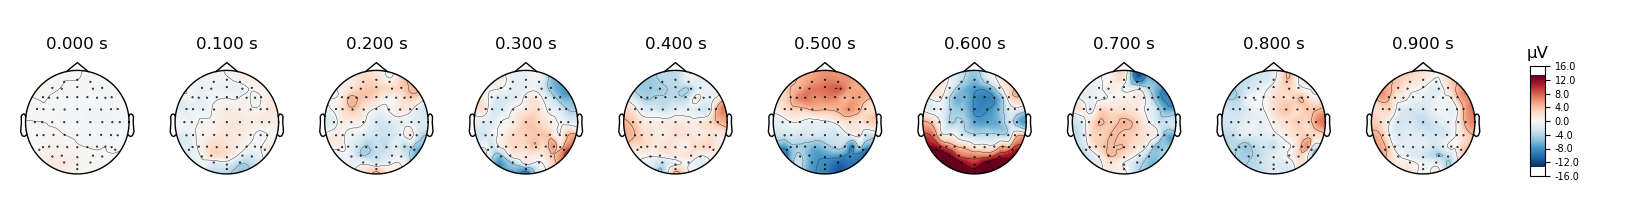

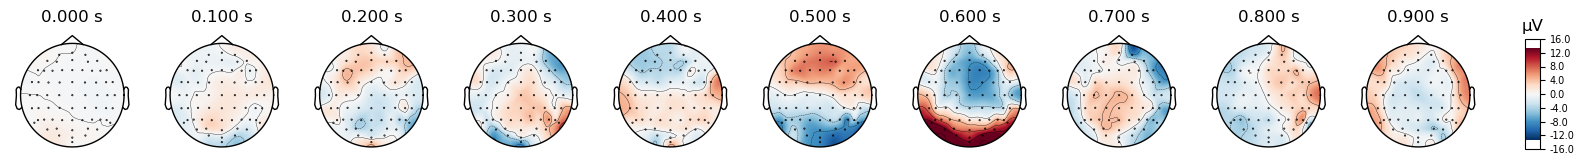

In [4]:
# Visualization
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=fs)
create_info.set_montage('biosemi64')
evoked = mne.EvokedArray(eeg_concat.T, create_info)
# evoked.plot_topomap(times=[i*60 for i in range(30)])
evoked.plot_topomap(times=[0.1*i for i in range(10)])
# The auditory cortex is the part of the temporal lobe that processes auditory information in humans and many other vertebrates.

    Using multitaper spectrum estimation with 7 DPSS windows


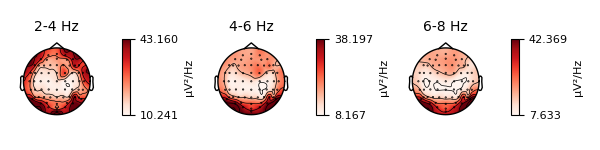

In [6]:
plt.close()
bands = {'2-4 Hz': (2, 4), '4-6 Hz': (4, 6),
         '6-8 Hz': (6, 8)}
evoked.compute_psd().plot_topomap(bands=bands)
plt.show()

### CCA

Run canonical component analysis

In [34]:
L_timefilter = int(fs)
n_components = 5
# Find the convolution matrix and run CCA (with all data)
conv_mtx = utils.convolution_mtx(L_timefilter, envelope_concat)
corr_coe, p_value, V_A, V_B = utils.cano_corr(eeg_concat, conv_mtx, n_components=n_components)
filtered_EEG = eeg_concat@V_A
filtered_Sti = conv_mtx@V_B
print('Note: no unseen data')
print('Correlation coefficients of the top {} components: {}'.format(n_components, corr_coe))
print('P-values of the top {} components: {}'.format(n_components, p_value))

Note: no unseen data
Correlation coefficients of the top 5 components: [0.11686609 0.09620335 0.07240313 0.06842679 0.06343767]
P-values of the top 5 components: [3.94214712e-119 3.56598895e-081 1.11737878e-046 7.21422346e-042
 3.23326068e-036]


In [35]:
# Cross validation
fold = 10
corr_train = np.zeros((fold, n_components))
corr_test = np.zeros((fold, n_components))
p_value_test = np.zeros((fold, n_components))
for idx in range(fold):
    EEG_train, EEG_test, Sti_train, Sti_test = utils.split(eeg_concat, envelope_concat, fold=fold, fold_idx=idx+1)
    conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
    corr_train[idx,:], p_value_train, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components)
    conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
    corr_test[idx,:], p_value_test[idx,:], _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train)
print('Average correlation coefficients of the top {} components on the training sets: {}'.format(n_components, np.average(corr_train, axis=0)))
print('Average correlation coefficients of the top {} components on the test sets: {}'.format(n_components, np.average(corr_test, axis=0)))
print('Average p-value of the top {} components on the test sets: {}'.format(n_components, np.average(p_value_test, axis=0)))

Average correlation coefficients of the top 5 components on the training sets: [0.11852258 0.09833431 0.07667584 0.07089222 0.06586683]
Average correlation coefficients of the top 5 components on the test sets: [ 0.08559859  0.05646651 -0.00213136  0.00943722  0.00889754]
Average p-value of the top 5 components on the test sets: [2.58302958e-05 4.05141766e-02 4.00758993e-01 4.03861826e-01
 2.71475442e-01]


correlation coefficient = [0.08859345 0.05516748 0.00922032 0.01345839 0.01008387], p-value = [4.01077855e-15 1.03331814e-06 4.14573219e-01 2.33687981e-01
 3.72238431e-01]%


100%|██████████| 1000/1000 [00:09<00:00, 107.72it/s]


Component 3, top 23.200000000000003%


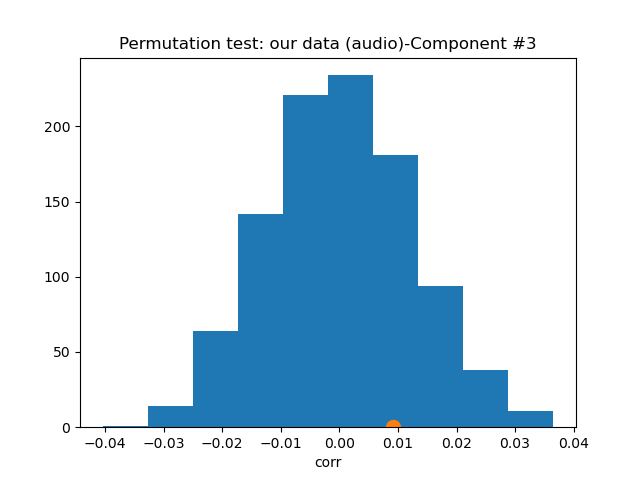

In [38]:
# Permutation test
fold = 5
idx = 1
EEG_train, EEG_test, Sti_train, Sti_test = utils.split(eeg_concat, envelope_concat, fold=fold, fold_idx=idx+1)
conv_mtx_train = utils.convolution_mtx(L_timefilter, Sti_train)
corr_train, _, V_A_train, V_B_train = utils.cano_corr(EEG_train, conv_mtx_train, n_components=n_components)
conv_mtx_test = utils.convolution_mtx(L_timefilter, Sti_test)
corr_test, p_value_test, _, _ = utils.cano_corr(EEG_test, conv_mtx_test, n_components=n_components, V_A=V_A_train, V_B=V_B_train)
print("correlation coefficient = {}, p-value = {}%".format(corr_test, p_value_test))
num_test=1000
corr_coe_topK = utils.permutation_test(EEG_test, Sti_test, num_test, t=1, fs=fs, topK=n_components, V_A=V_A_train, V_B=V_B_train)

compo = 3
corr_coe_list = corr_coe_topK[:,compo-1]
signifi = sum(corr_coe_topK[:,compo-1]>corr_test[compo-1])/num_test*100
print("Component {compo}, top {signifi}%".format(compo=compo, signifi=signifi))
plt.close()
plt.hist(corr_coe_topK[:,compo-1])
plt.title('Permutation test: our data (audio)-'+'Component #'+str(compo))
plt.xlabel('corr')
plt.plot(corr_test[compo-1], 0, marker="o", markersize=10)
plt.show()


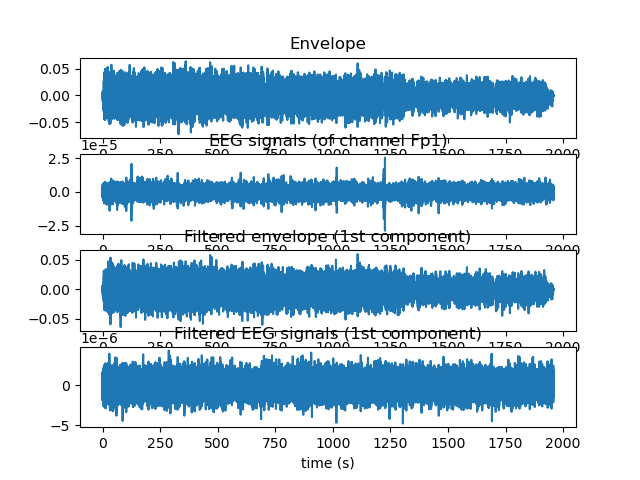

In [27]:
# Visualizations of component 1
plt.close()
compo = 1
ax1 = plt.subplot(411)
ax1.plot(times, envelope_concat)
ax1.title.set_text('Envelope')
ax2 = plt.subplot(412, sharex = ax1)
ax2.plot(times, eeg_concat[:,0])
ax2.title.set_text('EEG signals (of channel Fp1)')
ax3 = plt.subplot(413, sharex = ax1)
ax3.plot(times, filtered_Sti[:,compo-1])
ax3.title.set_text('Filtered envelope (1st component)')
ax4 = plt.subplot(414, sharex = ax1)
ax4.plot(times, filtered_EEG[:,compo-1])
ax4.title.set_text('Filtered EEG signals (1st component)')
ax4.set_xlabel('time (s)')
plt.show()

In [28]:
V_A[:,compo-1]

array([ 0.00207028,  0.00199487, -0.04886581, -0.24071101,  0.17382569,
       -0.05588135, -0.12973014, -0.02312574,  0.09012037,  0.06797102,
       -0.00399166, -0.07641248, -0.05500043,  0.43336204, -0.07296119,
       -0.20465733,  0.17055561,  0.14793419, -0.2144331 , -0.06759155,
       -0.04656809, -0.12690937, -0.0864239 ,  0.00182743,  0.08473327,
        0.10165528, -0.0024652 ,  0.00414121,  0.04842307, -0.14175605,
        0.13596168,  0.19613154,  0.05872356,  0.05865   , -0.16428048,
        0.03223919,  0.04770657, -0.13573025,  0.02041472,  0.08095943,
        0.06370635,  0.01180966, -0.04819823,  0.13042623,  0.10834079,
        0.01089866, -0.09716053, -0.13937686,  0.22039196,  0.19013864,
        0.05587841, -0.09371691, -0.3020257 ,  0.03289912, -0.16430246,
       -0.16567552, -0.15472299,  0.05951887,  0.00937388,  0.02354161,
        0.07086868,  0.03193765,  0.03049018,  0.05305262])

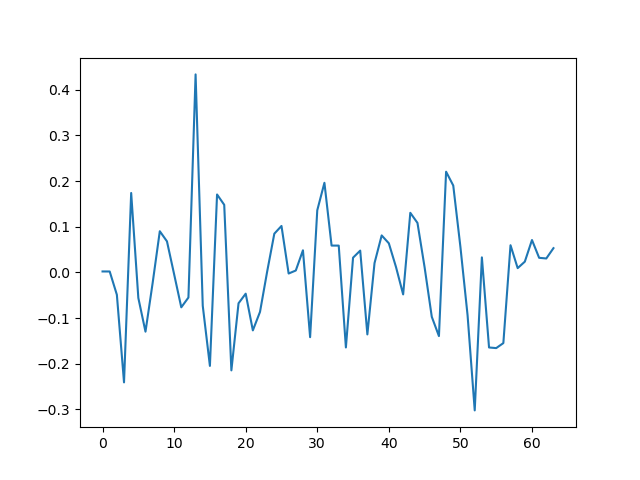

In [29]:
plt.close()
plt.plot(range(len(V_A[:,compo-1])), V_A[:,compo-1])
plt.show()

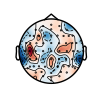

In [30]:
biosemi_layout = mne.channels.read_layout('biosemi')
create_info = mne.create_info(biosemi_layout.names, ch_types='eeg', sfreq=30)
create_info.set_montage('biosemi64')
plt.close()
mne.viz.plot_topomap(V_A[:,compo-1], create_info, ch_type='eeg')
plt.show()

In [31]:
V_B[:,compo-1]

array([-0.10649664,  0.02975654, -0.12031577,  0.69377396, -0.02806699,
       -0.22453555,  0.54503681, -0.28994116, -0.0351004 , -0.19527192,
       -0.03141401, -0.05104283,  0.08140684,  0.00084061,  0.041946  ,
       -0.01862383,  0.01819463, -0.06785057,  0.04663885, -0.0289907 ])

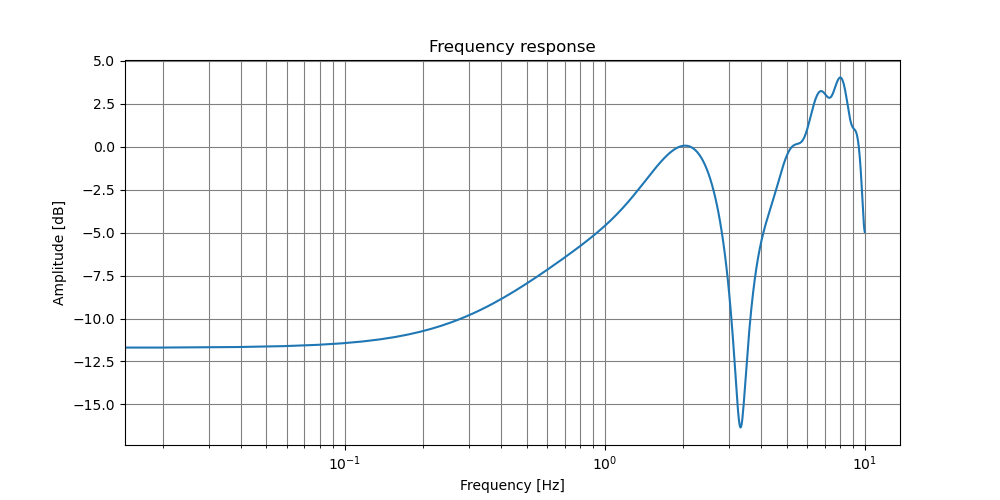

In [32]:
w, h = signal.freqz(b=V_B[:,compo-1], a=1)
x = w * fs * 1.0 / (2 * np.pi)
y = 20 * np.log10(abs(h))
plt.figure(figsize=(10,5))
plt.semilogx(x, y)
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.title('Frequency response')
plt.grid(which='both', linestyle='-', color='grey')
# plt.xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], ["20", "50", "100", "200", "500", "1K", "2K", "5K", "10K", "20K"])
plt.show()